In [1]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import sklearn.feature_selection as fs
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif, RFE

In [4]:
#Hagamos regresion logística con el data set FINAL

#Levantamos la data
data = pd.read_csv('PVR_train_test.csv')

#Generamos el X y el target
X= data.drop(['microzonificacion_Comercial',                   
'microzonificacion_Residencial suburbano',        
'microzonificacion_Residencial urbano',           
'macrozonificacion_Interfaz',                     
'macrozonificacion_Urbano', 'Target_NoApto'], axis=1)  
y= data['Target_NoApto']

#Divimos en train y en test
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size= 0.25, random_state= 42)

#Estandarizamos con MinMax
scaler = MinMaxScaler()

with open('./Models/logist-regresion-scaler.pkl', 'wb') as s:
    pickle.dump(scaler, s)

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

Lets select the best features

1) Por la varianza

In [5]:
from sklearn.feature_selection import VarianceThreshold

# Instanciamos la clase VarianceThreshold definiendo un threshold=0.5

fet_sel = VarianceThreshold(threshold=0.5)

# Fiteamos a fet_sel con nuestro df1:

fet_sel.fit(data)

VarianceThreshold(threshold=0.5)

In [6]:
fet_sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False])

In [7]:
# Podemos filtrar las columnas que no superen el umbral de varianza:

data.columns[fet_sel.get_support()]

Index(['poblacion', 'hogares', 'desocupado', '0-14', '65_mas', 'inicial',
       'primario', 'egb', 'secundario', 'polimodal', 'superior',
       'universitario', 'post_universitario', 'lee_y _esc', 'NoLee_ni_e',
       'hacinamiento', 'sin_agua', 'sin_cloaca', 'densidad_comercial'],
      dtype='object')

In [8]:
data_reduced = pd.DataFrame(fet_sel.transform(data), columns = data.columns[fet_sel.get_support()])
data_reduced.shape

(799, 19)

2) Select K best

/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass k=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass k=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass k=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass k=4 as keyw

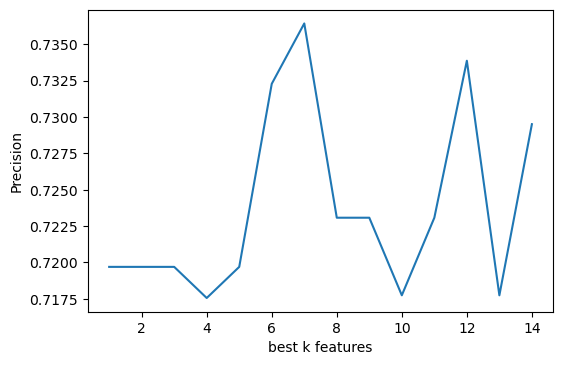

In [9]:
precision_list = []

for k in range(1, 15):
    
    bk = fs.SelectKBest(fs.f_classif, k)
    bk.fit(X_train, y_train)
    X_trans = bk.transform(X_train)
    train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                        y_train,
                                                        test_size=0.25,
                                                        random_state=42)
    
    lr = LogisticRegression()
    lr.fit(train_x, train_y)
    y_pred = lr.predict(test_x)
    precision = metrics.precision_score(test_y, y_pred)
    precision_list.append(precision)

fig, axe = plt.subplots(dpi = 100)
axe.plot(range(1, 15), precision_list)
axe.set_xlabel("best k features")
axe.set_ylabel("Precision")
plt.show(fig)

In [10]:
sel_f = SelectKBest(f_classif, k=7)
X_train_f = sel_f.fit_transform(X_train, y_train)
Boolean= sel_f.get_support()
print(X_train.loc[:,Boolean].columns)

Index(['poblacion', '0-14', 'primario', 'secundario', 'polimodal',
       'lee_y _esc', 'NoLee_ni_e'],
      dtype='object')


3) Recursive features elimination (RFE)

In [11]:
model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=12, step=1)
X_train_rfe_logistic = sel_rfe_logistic.fit_transform(X_train, y_train)
Boolean_RFE = sel_rfe_logistic.get_support()
print(X_train.loc[:,Boolean_RFE].columns)

/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Index(['poblacion', '0-14', 'inicial', 'egb', 'secundario', 'superior',
       'universitario', 'post_universitario', 'lee_y _esc', 'NoLee_ni_e',
       'hacinamiento', 'sin_cloaca'],
      dtype='object')


GridSearchCV

In [12]:
# Buscamos los mejores hiperparametros

X_best = data[['poblacion', '0-14', 'primario', 'secundario', 'polimodal',
       'lee_y _esc', 'NoLee_ni_e']]                      

X_best_std = scaler.fit_transform(X_best)

X_train_best, X_test_best, y_train, y_test = train_test_split(X_best_std,y, stratify=y, test_size= 0.25, random_state= 99)

modelo = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Defnimos una grilla con GridSearch

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3)
grid_search = GridSearchCV(estimator=modelo, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_best, y_train)

# Vemos los resultados

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.709559 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.704540 (0.054850) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.704540 (0.054850) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.704540 (0.054850) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.702318 (0.054311) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.702318 (0.054311) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.702318 (0.054311) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.706782 (0.055554) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.706782 (0.055554) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.709559 (0.053265) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.699521 (0.037301) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.699521 (0.037301) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.694502 (0.033078) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.689483 (0.015102) wit

In [13]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Oranges',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [15]:
#Instanciamos el modelo y los ajustamos a los datos de entrenamiento
modelo = LogisticRegression(C=100, penalty = 'l2', solver= 'newton-cg')
modelo.fit(X_train_best, y_train)

with open('./Models/logist-regresion.pkl', 'wb') as model_pk:
    pickle.dump(modelo, model_pk)


In [1]:
#Para UN solo fold
#Hacemos las predicciones necesarias
y_pred = modelo.predict(X_test_best)
print(y_pred)
#Evaluamos el score
print('')
print('Score: ', accuracy_score(y_test, y_pred))

NameError: name 'modelo' is not defined

In [ ]:
cf_matrix_a = confusion_matrix(y_pred,y_test)

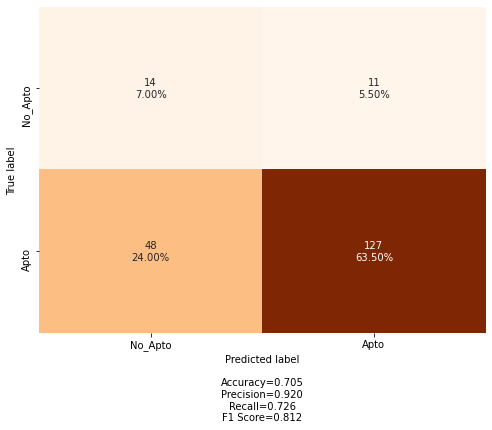

In [ ]:
make_confusion_matrix(cf_matrix_a, categories= ['No_Apto', 'Apto'] , figsize=(8,6), cbar=False)

In [ ]:
y_pred_proba = modelo.predict_proba(X_test_best)

In [ ]:
# Nos quedamos con la columna que tiene la probabilidad positiva de cada caso
y_probs_logit_left = y_pred_proba[:,1]

#Cambiamos el umbral
y_pred_logit = (y_probs_logit_left > 0.3).astype(int)
cf_matrix_a_logit = confusion_matrix(y_pred_logit,y_test)

In [ ]:
print('Matrix Original')
display(confusion_matrix(y_pred,y_test))
print('')
print('Nueva Matrix')
display(confusion_matrix(y_pred_logit,y_test))

Matrix Original


array([[ 14,  11],
       [ 48, 127]], dtype=int64)


Nueva Matrix


array([[  4,   2],
       [ 58, 136]], dtype=int64)

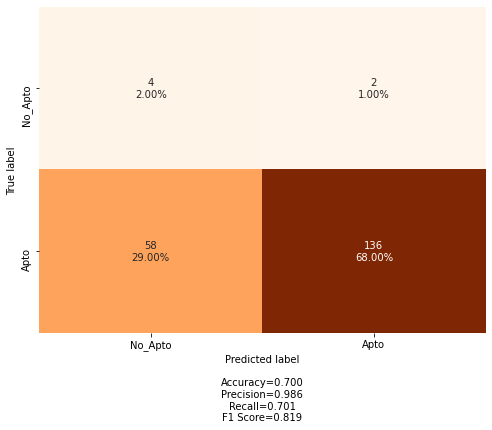

In [ ]:
make_confusion_matrix(cf_matrix_a_logit, categories= ['No_Apto','Apto'] , figsize=(8,6), cbar=False)

In [ ]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1])

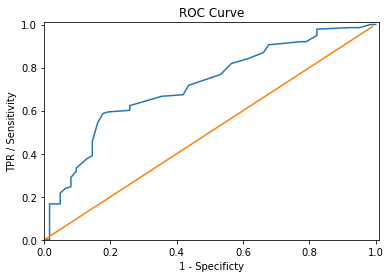

In [ ]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [ ]:
from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.7193197755960729


Hacemos las predicciones sobre todas las esquinas

In [ ]:
#Traemos los datos sobre las predicciones
PV = pd.read_csv('DAM_to_predict_PV.csv')
R = pd.read_csv('DAM_to_predict_R.csv')

In [ ]:
Prediciones_R = modelo.predict(R)
Predicciones_PV = modelo.predict(PV)

In [ ]:
Predicciones_PV

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [ ]:
Prediciones_R

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
PV['predicciones'] = Predicciones_PV
R['predicciones'] = Prediciones_R

In [ ]:
PV['predicciones'].value_counts()

1    2284
0      91
Name: predicciones, dtype: int64